In [1]:
# %pip install kaggle

In [2]:
# ! mkdir ~/.kaggle
 
# !cp kaggle.json ~/.kaggle/

In [3]:
# !kaggle competitions download -c store-sales-time-series-forecasting

# !unzip store-sales-time-series-forecasting.zip

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import os
import numpy as np

In [6]:
from matplotlib import style

style.available
# returns:
['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 '_classic_test']
style.use('seaborn-dark')


In [7]:
df_train=pd.read_csv('data/train.csv')
df_test=pd.read_csv('data/test.csv')
df_oil=pd.read_csv('data/oil.csv')
df_hollidays_events=pd.read_csv('data/holidays_events.csv')
df_stores=pd.read_csv('data/stores.csv')
df_transactions=pd.read_csv('data/transactions.csv')


In [8]:
#merge all data to df_train on date
df_train1=pd.merge(df_train,df_oil,on='date',how='left')
df_train1=pd.merge(df_train1,df_hollidays_events,on='date',how='left')
df_train1=pd.merge(df_train1,df_stores,on = 'store_nbr',how='left')
df_train1=pd.merge(df_train1,df_transactions,on = ['date', 'store_nbr'],how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

In [9]:
df_data = pd.concat([df_train, df_test], sort=True)

df_data = df_data.merge(df_stores, how="left", on='store_nbr')   
df_data = df_data.merge(df_oil, how="left", on='date')      
df_data = df_data.merge(df_transactions, how="left", on=['date','store_nbr'])  
df_data = df_data.merge(df_hollidays_events,on='date',how='left')
df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_data.date = pd.to_datetime(df_data.date)
df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()
df_data.head()

,date,family,id,onpromotion,sales,store_nbr,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01,AUTOMOTIVE,0,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,2013-01-01,BABY CARE,1,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
2,2013-01-01,BEAUTY,2,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
3,2013-01-01,BEVERAGES,3,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
4,2013-01-01,BOOKS,4,0,0.0,1,Quito,Pichincha,D,13,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday


In [10]:
df_train["date"] = pd.to_datetime(df_train.date)
df_test["date"] = pd.to_datetime(df_test.date)
df_transactions["date"] = pd.to_datetime(df_transactions.date)
df_oil["date"] = pd.to_datetime(df_oil.date)
df_train1["date"] = pd.to_datetime(df_oil.date)


In [11]:
%%time
df_st_sa=df_train1.groupby('store_type').agg({'sales':'mean'}).reset_index().reset_index().sort_values(by='sales', ascending=True)
df_fa_sa = df_train1.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_cl_sa = df_train1.groupby('cluster').agg({"sales" : "mean"}).reset_index() 
df_fa_sa=df_fa_sa.iloc[::-1]


CPU times: user 337 ms, sys: 68.3 ms, total: 405 ms
Wall time: 405 ms


In [12]:
df_fa_sa

,family,sales
9,DELI,265.629746
25,PERSONAL CARE,271.192381
24,MEATS,341.965905
28,POULTRY,351.078816
5,BREAD/BAKERY,464.150612
8,DAIRY,711.175991
7,CLEANING,1074.171518
30,PRODUCE,1355.373698
3,BEVERAGES,2394.912701
12,GROCERY I,3790.432797


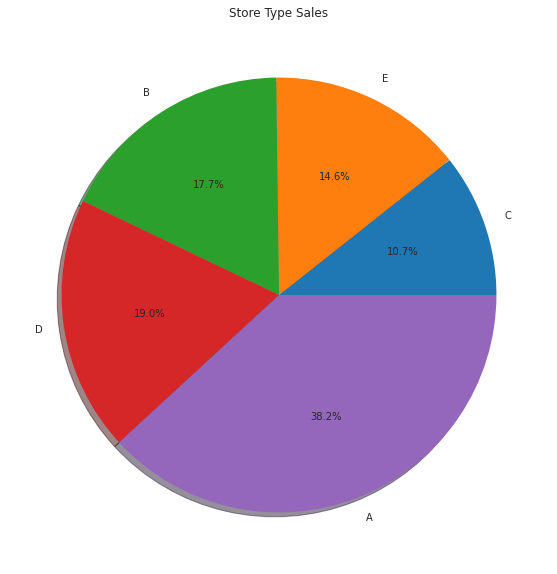

In [13]:
plt.figure(figsize=(10,10))

plt.pie(df_st_sa['sales'],labels=df_st_sa['store_type'],autopct='%1.1f%%',shadow=True)

plt.title('Store Type Sales')
plt.show()

Text(0, 0.5, 'Sales')

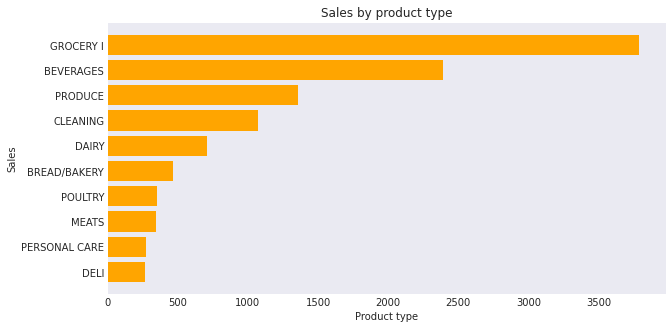

In [14]:
plt.figure(figsize=(10,5))
plt.barh(df_fa_sa['family'],df_fa_sa['sales'],color='orange')
plt.title('Sales by product type')
plt.xlabel('Product type')
plt.ylabel('Sales')

Text(0, 0.5, 'Sales')

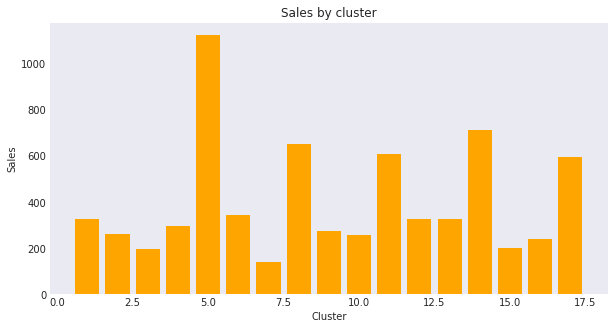

In [15]:
plt.figure(figsize=(10,5))
plt.bar(df_cl_sa['cluster'],df_cl_sa['sales'],color='orange')
plt.title('Sales by cluster')
plt.xlabel('Cluster')
plt.ylabel('Sales')

In [16]:
temp = pd.merge(df_train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), df_transactions, how = "left")
print("Spearman Correlation between Total Sales and Transactions: {:,.4f}".format(temp.corr("spearman").sales.loc["transactions"]))


Spearman Correlation between Total Sales and Transactions: 0.8175


In [17]:

a=df_transactions.set_index("date").resample('M').transactions.mean().reset_index()
a["year"] = a.date.dt.year
a

,date,transactions,year
0,2013-01-31,1657.898624,2013
1,2013-02-28,1684.483696,2013
2,2013-03-31,1724.181627,2013
3,2013-04-30,1699.206522,2013
4,2013-05-31,1702.874396,2013
5,2013-06-30,1701.426743,2013
6,2013-07-31,1675.012552,2013
7,2013-08-31,1689.182567,2013
8,2013-09-30,1688.270922,2013
9,2013-10-31,1653.013040,2013


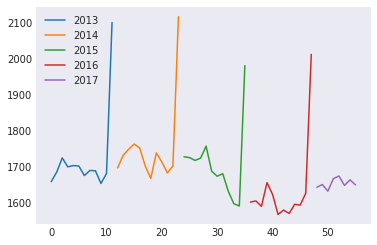

In [18]:
a.groupby("year").transactions.plot()
plt.legend(a.year.unique())

plt.show()

The figure showing strong correlation between transaction and sales

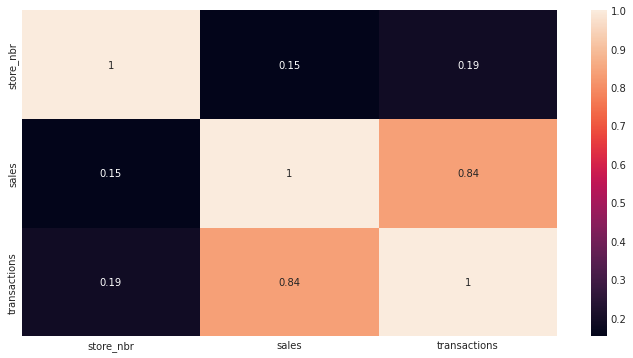

In [19]:
plt.figure(figsize=(12,6))
sns.heatmap(temp.corr(), annot=True)
plt.show()

In [20]:
a = df_transactions.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).transactions.mean().reset_index()

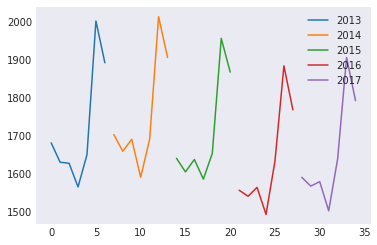

In [21]:
a.groupby("year").transactions.plot()
plt.legend(a.year.unique())

OIL PRICES

In [22]:
oil = df_oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
# Plot
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')

In [ ]:
sns.lineplot(x="date", y="value", data=p)
plt.legend(p.Legend.unique())
plt.xlabel("Date")
plt.ylabel("Oil Price")
plt.show()

In [ ]:
df_data['dcoilwtico'] = df_data['dcoilwtico'].fillna(method='bfill')
df_data.dcoilwtico.isnull().sum()

In [ ]:
df_data.transactions = df_data.transactions.replace(np.nan,0)

In [ ]:
temp = pd.merge(temp, oil, how = "left")
print("Correlation with Daily Oil Prices")
print(temp.drop(["store_nbr", "dcoilwtico"], axis = 1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")


First of all, let's look at the correlations for sales and transactions. The correlation values are not strong but the sign of sales is negative. Maybe, we can catch a clue. Logically, if daily oil price is high, we expect that the Ecuador's economy is bad and it means the price of product increases and sales decreases. There is a negative relationship here.

In [ ]:
a = df_train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()

In [ ]:
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

In [ ]:
df_train['family'] = df_train['family'].astype('category')
df_train['family_category'] = df_train['family'].cat.codes
family_category = dict( zip( df_train['family'].cat.codes, df_train['family'] ) )
data_grouped_family_types = df_train.groupby(['family_category']).mean()[['sales', 'onpromotion']]
#find percent  of sales
data_grouped_family_types['%_s'] = 100 * data_grouped_family_types['sales'] / data_grouped_family_types['sales'].sum()
data_grouped_family_types['%_s'] = data_grouped_family_types['%_s'].round(decimals = 3)
data_grouped_family_types

In [ ]:
percent=data_grouped_family_types['%_s']
family=data_grouped_family_types.index
#find labels from family_category
lables_2 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(family_category.values(), percent)]
patches, texts=plt.pie(percent, shadow=True, startangle=90,radius=1.5)


patches, labels, dummy =  zip(*sorted(zip(patches, lables_2,data_grouped_family_types['%_s']),key=lambda x: x[2],reverse=True))
#plot pie chart
#plot pie chart
plt.legend(patches, labels, loc="best",bbox_to_anchor=(-0.1, 1.), fontsize=8)
plt.axis('equal')
plt.title('Percentage of Sales by Family Type')
plt.show()

In [ ]:
#onpromotion percent
data_grouped_family_types['%_p'] = 100 * data_grouped_family_types['onpromotion'] / data_grouped_family_types['onpromotion'].sum()
data_grouped_family_types['%_p'] = data_grouped_family_types['%_p'].round(decimals = 3)
data_grouped_family_types

In [ ]:
percent=data_grouped_family_types['%_p']
family=data_grouped_family_types.index
#find labels from family_category
lables_2 = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(family_category.values(), percent)]
patches, texts=plt.pie(percent, shadow=True, startangle=90,radius=1.5)
patches, labels, dummy =  zip(*sorted(zip(patches, lables_2,data_grouped_family_types['%_p']),key=lambda x: x[2],reverse=True))
#plot pie chart
plt.legend(patches, labels, loc="best",bbox_to_anchor=(-0.1, 1.), fontsize=8)
plt.axis('equal')
plt.title('Percentage of On-Promotion Sales by Family Type')
plt.show()

In [ ]:
df_train['day_of_week']=df_train['date'].dt.dayofweek

In [ ]:
weekly_sales=df_train.groupby('day_of_week').mean()['sales']
plt.figure(figsize=(10,5))
plt.bar(weekly_sales.index+1, weekly_sales.values)
plt.title('Weekly Sales')
plt.xlabel('Day of Week')
plt.show()

In [ ]:
#monthly sales
df_train['month']=df_train['date'].dt.month
monthly_sales=df_train.groupby('month').mean()['sales']
#plot monthly sales as bar chart
monthly_sales.plot(kind='bar')

In [ ]:
#yearly sales
df_train['year']=df_train['date'].dt.year
yearly_sales=df_train.groupby('year').mean()['sales']
#plot yearly sales as bar chart
yearly_sales.plot(kind='bar')


In [ ]:
day_type = df_hollidays_events[['date', 'type']]
avg_sales = df_train.groupby('date').agg({'sales':'mean'}).reset_index()

day_type['date'] = pd.to_datetime(day_type['date'])
avg_sales['date'] = pd.to_datetime(avg_sales['date'])

#print(day_type.head())
#print(avg_sales.head())

df = pd.merge_asof(day_type, avg_sales, on = 'date')
df.dropna(inplace= True)
df.reset_index(drop = True, inplace= True)

#print(df.head())

df_1 = df.groupby(['type']).mean()['sales']
average_holiday_sales = df_1.mean()
#print(df_1.head())

print(f'average holiday sales is {average_holiday_sales}')

df_1.plot(kind='bar', figsize = (12,6)).set_title('average holiday sales')

In [ ]:
import psutil
# gives a single float value
psutil.cpu_percent(interval=1, percpu=True)

In [ ]:
avg_sales=df_train.groupby('date').agg({'sales':'mean'})
avg_sales.reset_index(inplace=True)
avg_sales.rename(columns={'sales':'avg_sales'},inplace=True)
avg_sales.head()

In [ ]:
avg_sales['lag_1']=avg_sales['avg_sales'].shift(1)
avg_sales

In [ ]:
sns.regplot(x='lag_1', y='avg_sales', data=avg_sales,scatter_kws={"color": "black"}, line_kws={"color": "red"})

In [ ]:
#the above plot show linear relationship
#fit linear regression
from sklearn.linear_model import LinearRegression
avg_sales['lag_1'].fillna(0,inplace=True)

X=avg_sales.loc[:, ['lag_1']]
y=avg_sales['avg_sales']
regressor=LinearRegression()
regressor.fit(X,y)
y_pred=pd.Series(regressor.predict(X),index=X.index)
#plot the regression line


In [ ]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of sales');

In [ ]:
ax = y.plot()
ax = y_pred.plot()

**Trend**

**What is Trend ?**
The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

**Moving Average Plot**
To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

In [ ]:
#rolling window
avg_sales=df_train.groupby('date').agg({'sales':'mean'}).reset_index()
avg_sales=avg_sales.set_index('date').to_period("D")
avg_sales.rename(columns={'sales':'avg_sales'},inplace=True)
moving_avg=avg_sales['avg_sales'].rolling(
    window=365, center=True, 
    min_periods=187
    ).mean()
ax = avg_sales.plot(style=".", color="0.5")
moving_avg.plot(ax=ax)

**Interpret:** As we can appreeciate, sales has an constantly increasing trend during recorded years.



In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess
dp=DeterministicProcess(
    index=avg_sales.index,
    constant=True,
    order=1,
    drop=True
)
X= dp.in_sample()
X.head()

In [ ]:
from sklearn.linear_model import LinearRegression
y=avg_sales['avg_sales']
reg=LinearRegression()
reg.fit(X,y)
y_pred=pd.Series(reg.predict(X),index=X.index)

In [ ]:
ax = avg_sales.plot(style=".", color="0.5", title="sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [ ]:
X = dp.out_of_sample(steps=180)

y_fore = pd.Series(reg.predict(X), index=X.index)

y_fore.head()

**Seasonality** <br>
We say that a time series exhibits seasonality whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar - repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Load the sales dataset
avg_sales = df_train.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales.head()

In [ ]:
X = avg_sales.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (freq)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

In [ ]:
#plot_periodogram(avg_sales.sales);

y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

**Interpret:** both the seasonal plot and the periodogram suggest a strong weekly seasonality, and a weak annual seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(avg_sales['sales'], period=365, model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(22,10))
ax[0,0].set_title('Observed values for Sales', fontsize=16)
decomp.observed.plot(ax = ax[0,0], legend=False, color='dodgerblue')

ax[0,1].set_title('Sales Trend', fontsize=16)
decomp.trend.plot(ax = ax[0,1],legend=False, color='dodgerblue')

ax[1,0].set_title('Sales Seasonality', fontsize=16)
decomp.seasonal.plot(ax = ax[1,0],legend=False, color='dodgerblue')

ax[1,1].set_title('Noise', fontsize=16)
decomp.resid.plot(ax = ax[1,1],legend=False, color='dodgerblue')

**Stationarity**

**What is Stationarity ?**
A stationary Time Series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary. A time series with cyclic behaviour (but with no trend or seasonality) is stationary.

**Strong stationarity:** is a stochastic process whose unconditional joint probability distribution does not change when shifted in time. Consequently, parameters such as mean and variance also do not change over time.
Weak stationarity: is a process where mean, variance, autocorrelation are constant throughout the time
Stationarity is important as non-stationary series that depend on time have too many parameters to account for when modelling the time series. diff method() can easily convert a non-stationary series to a stationary series.

**What is stationarity used for ?**
Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary. Forecasting a stationary series is relatively easier and the forecasts are more reliable. We know that linear regression works best if the predictors (X variables) are not correlated against each other. So, stationarizing the series solves this problem since it removes any persistent autocorrelation, thereby making the predictors (lags of the series) in the forecasting models nearly independent.

**How to make a Time Series stationary ?**
There are several ways to do that:

Difference the series once or more times (subtracting the next value by the current value)
Take the log of the series (helps to stabilize the variance of a time series.)
Take the 𝑛𝑡ℎ root of the series Combinations of the above
But first, to test if a time series is stationary we can:

Look at the time plot.
Split the series into 2 parts and compute descriptive statistics. If they differ, then it is not stationary.
Perform statistical tests called Unit Root Tests like Augmented Dickey Fuller test (ADF Test), Kwiatkowski-Phillips-Schmidt-Shin — KPSS test (trend stationary), and Philips Perron test (PP Test).
The most commonly used is the **ADF test**, where the null hypothesis is that the time series possesses a unit root (or random walk with drift) and is non-stationary. So, if the P-Value in ADF test is less than the significance level (0.05), you reject the null hypothesis and the series is stationary.

In [ ]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    # .to_string() removes the line "dtype: float64"
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
# Aggregating the Time Series to a monthly scaled index
y = df_train[['date','sales']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
        
adf_test(y['sales'],title='') 

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed. The two most common methods to transform series into stationarity ones are:

Transformation: e.g. log or square root to stabilize non-constant variance
Differencing: subtracts the current value from the previous
Hereafter, we are going to transform sales trend from non-stationarity to stationarity using diff method:

In [ ]:
fig = plt.figure(figsize=(22,8))
decomp.trend.diff().plot()

**Autocorrelation Analysis**

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the autocorrelation function and partial autocorrelation function plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

Autocorrelation Function (ACF): P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
Partial Autocorrelation Function (PACF): D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

In [ ]:
#this take infinite time!
# from statsmodels.tsa.stattools import acf
# import datetime
# def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
#     from matplotlib.offsetbox import AnchoredText
#     x_ = x.shift(lag)
#     if standardize:
#         x_ = (x_ - x_.mean()) / x_.std()
#     if y is not None:
#         y_ = (y - y.mean()) / y.std() if standardize else y
#     else:
#         y_ = x
#     corr = y_.corr(x_)
#     if ax is None:
#         fig, ax = plt.subplots()
#     scatter_kws = dict(
#         alpha=0.75,
#         s=3,
#     )
#     line_kws = dict(color='C3', )
#     ax = sns.regplot(x=x_,
#                      y=y_,
#                      scatter_kws=scatter_kws,
#                      line_kws=line_kws,
#                      lowess=True,
#                      ax=ax,
#                      **kwargs)
#     at = AnchoredText(
#         f"{corr:.2f}",
#         prop=dict(size="large"),
#         frameon=True,
#         loc="upper left",
#     )
#     at.patch.set_boxstyle("square, pad=0.0")
#     ax.add_artist(at)
#     ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
#     return ax
# def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
#     import math
#     kwargs.setdefault('nrows', nrows)
#     kwargs.setdefault('ncols', math.ceil(lags / nrows))
#     kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
#     fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
#     for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
#         if k + 1 <= lags:
#             ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
#             ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
#             ax.set(xlabel="", ylabel="")
#         else:
#             ax.axis('off')
#     plt.setp(axs[-1, :], xlabel=x.name)
#     plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
#     fig.tight_layout(w_pad=0.1, h_pad=0.1)
#     return fig
# fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))
# plot_lags(df_train[df_train.date >= datetime.datetime(2017,1,1)]['sales'], lags=12, nrows=2)
# plot_acf(df_train[df_data.date >= datetime.datetime(2017,1,1)]['sales'].tolist(), lags=12, ax=ax[0], fft=False);
# plot_pacf(df_train[df_train.date >= datetime.datetime(2017,1,1)]['sales'].tolist(), lags=12, ax=ax[1]);

**Interpret:** For autocorrelation, the y-axis is the value for the correlation between a value and its lag. The lag is on the x-axis. The zero-lag has a correlation of 1 because it correlates with itself perfectly.

**label encoder** 
Transferring non numerical feature into numbers


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
non_numerical_cols =  [col for col in df_data.columns if df_data[col].dtype == 'object']
for feature in non_numerical_cols:        
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])


In [ ]:
df_data.head().style.set_properties(subset=non_numerical_cols, **{'background-color': '#F1C40F'})

In [ ]:
df_data.dtypes

**one hot encoding**
To finish with, we are going to one hot encoded non-ordinal features. All labeled features above are non-ordinal features. Therefore, we are going to one hot encoded those which have a low cardinality.

In [ ]:
low_card_cols = [col for col in non_numerical_cols if len(df_data[col].unique()) < 15]

In [ ]:
encoded_features = []

for feature in low_card_cols:
    encoded_feat = OneHotEncoder().fit_transform(df_data[feature].values.reshape(-1, 1)).toarray()
    n = df_data[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = df_data.index
    encoded_features.append(encoded_df)

df_data = pd.concat([df_data, *encoded_features[:9]], axis=1)

In [ ]:
df_data.head().style.set_properties(subset=low_card_cols, **{'background-color': '#F1C40F'})

In [ ]:
df_data = df_data.drop(low_card_cols,axis=1)


**Modelling**<br>
**Cross Validation**

Time series can be either univariate or multivariate:

Univariate time series only has a single time-dependent variable.
Multivariate time series have a multiple time-dependent variable.
But, first of all we are going to see how does cross validation technic works in TimeSeries Analysis.


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
N_SPLITS = 3

X = df_data['date']
y = df_data['sales']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [ ]:
# f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(22, 10))

# for i, (train_index, valid_index) in enumerate(folds.split(X)):
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

#     sns.lineplot(
#         x=X_train, 
#         y=y_train, 
#         ax=ax[i,0], 
#         color='dodgerblue', 
#         label='train'
#     )
#     sns.lineplot(
#         x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
#         y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
#         ax=ax[i,1], 
#         color='dodgerblue', 
#         label='train'
#     )

#     for j in range(2):
#         sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
#     ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
#     ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

# plt.tight_layout()
# plt.show()

**Univariate Time Series Models**

**Prophet**<br>
The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet. Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook. Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays. In our case, we are going to use it to show average sales per day (it is an univariate time series)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import datetime
from fbprophet import Prophet

train = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales']].groupby('date').mean().reset_index('date')
train.columns = ['ds', 'y']

x_valid=df_test[['id','date']]
x_valid=x_valid.set_index('id')
x_valid.columns = ['ds']

# Train the model
model = Prophet()
model.fit(train)
y_pred = model.predict(x_valid)

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model.plot(y_pred, ax=ax)
sns.lineplot(x=train['ds'], y=train['y'], ax=ax, color='darkorange') #navajowhite

#ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales per Day')

plt.show()

In [ ]:
train_multivariate = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales','dcoilwtico','onpromotion','transactions','family']].groupby('date').mean().reset_index('date')
train_multivariate

In [ ]:
x_valid = pd.DataFrame(df_data[df_data['date']>= datetime.datetime(2017,8,16)][['date','dcoilwtico','onpromotion','transactions','family']])
x_valid

In [ ]:
s1=pd.read_csv('data/sample_submission.csv')
s1['sales']=pred.values

In [ ]:
s1.to_csv('mysub.csv',index=False)

Multivariate Time Series Models

In [ ]:
train_multivariate = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales','dcoilwtico','onpromotion','transactions','family']].groupby('date').mean().reset_index('date')
train_multivariate.columns = ['ds', 'y','dcoilwtico','onpromotion','transactions','family']
x_valid = pd.DataFrame(df_data[df_data['date']>= datetime.datetime(2017,8,16)][['date','dcoilwtico','onpromotion','transactions','family']])
x_valid.columns = ['ds','dcoilwtico','onpromotion','transactions','family']

# Train the model
model_multivariate = Prophet()
model_multivariate.add_regressor('dcoilwtico')

model_multivariate.fit(train_multivariate)
y_pred_multivariate = model_multivariate.predict(x_valid)

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(22)

model.plot(y_pred_multivariate, ax=ax)
sns.lineplot(x=train_multivariate['ds'], y=train_multivariate['y'], ax=ax, color='darkorange') #navajowhite

#ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)
ax.set_title('Average Sales per Day')

plt.show()

**ARIMA Model:**
in autocorrelation, if one value was correlated with the present, the next value is also the present. For this, we need to look at Partial Autocorrelations, because this way we eliminate the effects of past values for the next value.

We need found a stationary serie because is easy to predict. The statistical properties of the past will be the same as in the future. Time series with trend and seasonality are not stationary, because these characteristics affect the value of the series at different times. For this, we use the Dicked-fuller test: p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is station

In [ ]:
df_data.index.asfreq('D')

In [ ]:
fig,ax=plt.subplots(nrows=2,ncols=1)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
ax[0].set_title("ACF")
plot_acf(df_data['sales'],lags=30,zero=False,ax=ax[0])
ax[1].set_title("PACF")
plot_pacf(df_data['sales'],lags=30,zero=False,ax=ax[1],method='ywm')
plt.show()

In [ ]:
import datetime
train_data = df_data[df_data['date']<= datetime.datetime(2017,8,15)][['date','sales','dcoilwtico','onpromotion','transactions','family','holiday_type']].groupby('date').mean().reset_index('date')
test_data = pd.DataFrame(df_data[df_data['date']>= datetime.datetime(2017,8,16)][['date','dcoilwtico','onpromotion','transactions','family']])


In [ ]:
from statsmodels.tsa.stattools import adfuller
y = train_data[['date','sales']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
p_value_adfuller = adfuller(y['sales'])[1]
print(p_value_adfuller)

We can either transform the series to stationary by calculating the differences between consecutive observations or transform the value to logarithmic.

In [ ]:
train_data['diff_sales'] = train_data['sales'].diff()
y = train_data[['date','diff_sales']].copy()
y.set_index('date', inplace=True)
y.index = pd.to_datetime(y.index)
y = y.resample('1M').mean()
p_value_adfuller = adfuller(y['diff_sales'])[1]
print(p_value_adfuller)

In [ ]:
train_data['diff_onpromotion'] =train_data['onpromotion'].diff()
train_data['diff_dcoilwtico'] =  train_data['dcoilwtico'].diff()

In [ ]:
train_data.corr()

In [ ]:
train_data

In [ ]:
import datetime
train_data=train_data.fillna(0)
train_data.index=train_data['date']
train_data=train_data.drop('date',axis=1)

In [ ]:
import pmdarima as pm
model = pm.auto_arima(train_data['diff_sales'],seasonal=True,maxiter=10, m=7,exog=train_data[['diff_onpromotion','diff_dcoilwtico']])

model.aic()

model.fit(train_data['diff_sales'])

In [ ]:
pred=model.predict(n_periods=28512,exog=test_data[['diff_onpromotion','diff_dcoilwtico']])
pred=pd.DataFrame(pred,index=test_data.index)

In [ ]:
pred[:100].plot()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima_train = train_data.dropna().copy()

model_arima =ARIMA(arima_train['diff_sales'], exog=arima_train[['diff_onpromotion','diff_dcoilwtico']], order=(6,0,2))
result = model_arima.fit(method_kwargs={"warn_convergence": False})

print(result.summary())

In [ ]:
test_data['diff_onpromotion'] =test_data['onpromotion'].diff()
test_data['diff_dcoilwtico'] =  test_data['dcoilwtico'].diff()


In [ ]:
test_data.index=test_data['date']
test_data=test_data.drop('date',axis=1)

In [ ]:
test_data

In [ ]:

test=test_data.dropna().copy()
from pandas import datetime
start_index =1603
end_index = 30193
pred=result.predict(start=start_index,end=end_index,
                   exog=test[['diff_onpromotion','diff_dcoilwtico']])

In [ ]:
pred.values

In [ ]:
test[['diff_onpromotion','diff_dcoilwtico']]

In [ ]:
pred.values.shape

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=avg_sales.index,
    constant=True,   # dummy feature for bias (y-intercept)
    order=1,         # trend ( order 1 means linear)
    seasonal=True,   # weekly seasonality (indicators)
    additional_terms=[fourier], # annual seasonality
    drop=True,       # drop terms to avoid collinearity
)

X = dp.in_sample() # creat

In [ ]:
y = avg_sales["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [ ]:
store_sales = pd.read_csv(
    'data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [ ]:
df_test = pd.read_csv(
    'data/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


In [ ]:
pred.shape

In [ ]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])

y_submit.to_csv('submission.csv', index=False)

In [ ]:
y_submit.to_csv('sub10.csv', index=False)

In [ ]:
y_submit.head(5)

In [ ]:
df_test

In [ ]:
s1=pd.read_csv('submission.csv')

In [ ]:
s2=pd.read_csv('submission (6).csv')

Time series as feature

In [ ]:
store_sales = pd.read_csv(
    'data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

mag_sales = family_sales.loc(axis=1)[:, 'MAGAZINES']

store_sales.head()

In [ ]:
y = mag_sales.loc[:, 'sales'].squeeze()
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Magazine Sales (deseasonalized)");


In [ ]:
y_ma = y.rolling(7, center=True).mean()


# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

In [ ]:
onpromotion = mag_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop the New Year outlier
plot_lags(x=onpromotion.iloc[1:], y=y_deseason.iloc[1:], lags=3, leads=3, nrows=1);

Tried neural network but did not work good

In [ ]:
df_train_data=df_data.drop(columns=['id','date'])
df_train_data=df_train_data.dropna()

X=df_train_data.drop(columns=['sales']).values
y=df_train_data.sales.values
X = np.asarray(X).astype('float32')
y= np.asarray(y).astype('float32')


In [ ]:
import tensorflow as tf
#simple dnn (input has 19 features)
model=tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=100,input_shape=[19]))
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer='adam',loss='mse')
model.fit(X,y,epochs=10,batch_size=4,verbose=2)